<a href="https://colab.research.google.com/github/jaintriago/COVID-19/blob/master/sr_books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R
install.packages("recommenderlab", dependencies = T)
install.packages("funModeling", dependencies = T)
install.packages("reshape2", dependencies = T)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘bitops’, ‘gtools’, ‘gdata’, ‘caTools’, ‘RcppProgress’, ‘gplots’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’, ‘ROCR’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/bitops_1.0-6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 8734 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [4]:
%%R
library(tidyverse)
library(recommenderlab)
library(reshape2)
library(readxl)
library(funModeling)
library(ggplot2)
#library(plotly)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loading required package: arules

R[write to console]: 
Attaching package: ‘arules’


R[write to console]: The following object is masked from ‘package:dplyr’:

    recode


R[write to console]: The following objects are masked from ‘package:base’:

    abbreviate, write


R[write to console]: Loading required package

In [5]:
%%R
ratings<-read.csv("/content/drive/My Drive/BX-Book-Ratings.csv",sep=";")
libros<-read.csv("/content/drive/My Drive/BX-Books.csv",sep=";")
usuarios<-read.csv("/content/drive/My Drive/BX-Users.csv",sep=";")


In [6]:
%%R
names(ratings)<-c("idUsuario","idLibro","rating")
names(libros)<-c("idLibro","titulo","autor","anyoPublicacion","editorial","imagen1","imagen2","imagen3")
names(usuarios)<-c("idUsuario","ubicacion","edad")

In [18]:
%%R
head(usuarios)

  idUsuario                          ubicacion edad
1         2          stockton, california, usa   18
2         3    moscow, yukon territory, russia  \\N
3         4          porto, v.n.gaia, portugal   17
4         5 farnborough, hants, united kingdom  \\N
5         6      santa monica, california, usa   61
6         7                washington, dc, usa  \\N


In [7]:
%%R
# Vamos a quitar las columnas que no vamos a necesitar
libros$imagen1=NULL
libros$imagen2=NULL
libros$imagen3=NULL

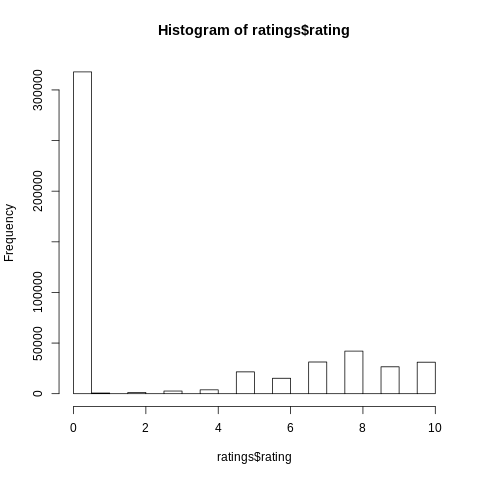

In [8]:
%%R

# Vamos a reducir el tamaño de la matriz para poder cargarla 
hist(ratings$rating)
summary(ratings$rating)
# Vamos a quitar primero aquellos que hayan valorado a 0 libro (sí, perdemos información, pero...)
ratings<-ratings[which(ratings$rating>0),]

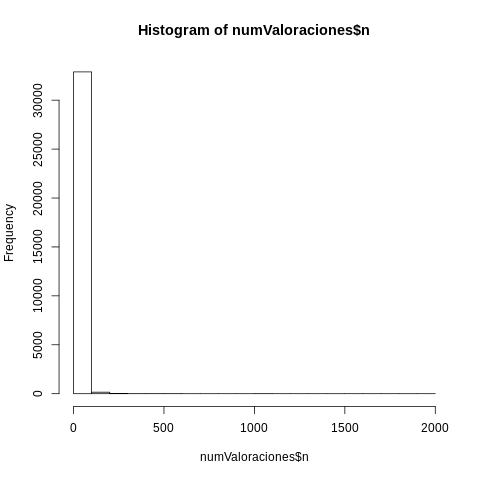

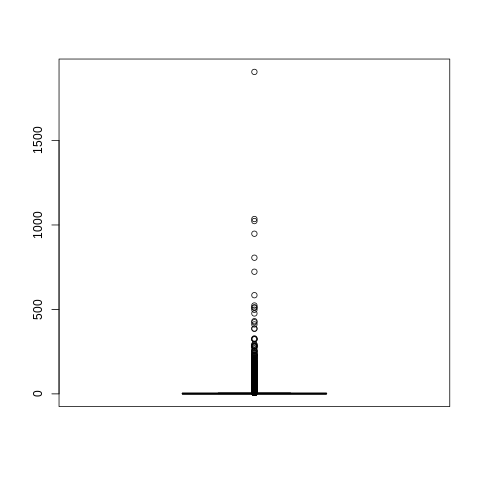

In [9]:
%%R

# Primero vamos a sacar cuántas valoraciones han hecho los usuarios
numValoraciones<- ratings %>% 
  group_by(idUsuario) %>% count() 
hist(numValoraciones$n)
boxplot(numValoraciones$n)

In [10]:
%%R

# Y ahora vamos a quitar a usuarios que hayan valorado pocos libros
usuarios_excluidos <- ratings %>% filter(!is.na(rating)) %>%
  group_by(idUsuario) %>% count() %>% filter(n < 5) %>%
  pull(idUsuario)
ratings <- ratings %>% filter(!idUsuario %in% usuarios_excluidos)

In [11]:
%%R

ratingsmat = dcast(ratings, idUsuario~idLibro, value.var = "rating", na.rm=FALSE)
# Lo convertimos a matriz
ratingsmat = as.matrix(ratingsmat[,-1])

In [12]:
%%R

ratingsmat = as(ratingsmat, "realRatingMatrix")

In [13]:
%%R

rec_mod = Recommender(ratingsmat, method = "UBCF", param=list(method="Cosine",nn=10))

In [14]:
%%R

top5recomendaciones = predict(rec_mod, ratingsmat[16], n=5)

In [15]:
%%R

# Para poder ver las recomendaciones, vamos a convertir las mismas en una lista e imprimirlas en pantalla: 
top5recomendaciones = as(top5recomendaciones, "list")
top5recomendaciones


[[1]]
[1] "0385315546" "0671023888" "014024249X" "0452275849" "0553572997"



In [16]:
%%R

# Aquí tenemos los códigos de productos: pero, ¿qué productos son? 
# Vamos lo primero de todo a convertir la lista a un dataframe y cambiar el nombre de la columna
top5df=data.frame(top5recomendaciones)
colnames(top5df)="idLibro"

In [17]:
%%R

# Mezclamos este dato con el dataframe donde tenemos los detalles de los libros
nombreLibros=left_join(top5df, libros, by="idLibro")
nombreLibros


     idLibro                                               titulo
1 0385315546                                                 <NA>
2 0671023888                                       All She Wanted
3 014024249X                The Penguin Book of Gay Short Stories
4 0452275849 When the Music's over: My Journey into Schizophrenia
5 0553572997                                         The Alienist
            autor anyoPublicacion     editorial
1            <NA>            <NA>          <NA>
2 Aphrodite Jones            1996        Pocket
3   David Leavitt            1994 Penguin Books
4      Ross Burke            1996   Penguin USA
5      Caleb Carr            1995  Bantam Books
